In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import tabulate

In [2]:
# Set plotting style
plt.style.use('seaborn-white')

current_palette = sns.color_palette()


COLOR_MAP = {
 "Male": current_palette[0],
 "Female": current_palette[1],
}

%matplotlib inline

# Helper functions

In [3]:
def make_markdown_table(df, by, val="total_recurring_comp"):
    frame = df[[by, val]].groupby([by]).agg({val: ["count", "median"]})
    
    print(tabulate.tabulate(frame, tablefmt="pipe", headers="keys"))

In [4]:
def add_custom_legend(plt):
    leg = plt.legend(
        loc="upper right",
        fontsize=32,
        ncol=1,
        frameon=1,
        fancybox=True,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
    )

    # Turn on and theme the frame
    frame = leg.get_frame()
    frame.set_alpha(0)

    # Set the legend text color to match the line color
    ax = plt.gca()
    handles, _ = ax.get_legend_handles_labels()
    texts = leg.get_texts()
    for _, text in zip(handles, texts):
        text.set_color(COLOR_MAP[text.get_text()])
        text.set_path_effects(
            [
                path_effects.Stroke(linewidth=1, foreground='black'),
                path_effects.Normal(),
            ]
        )

    fig.tight_layout()

In [5]:
def make_plot(df, x, y, file, hue=None, y_label="", x_label="", order=None, legend=False):
    # Set plot size
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

    ax = sns.swarmplot(
        data=df, 
        x=x, 
        y=y,
        hue=hue,
        linewidth=2,
        order=order,
        s=12,
        dodge=True,
    )
    
    # Remove legend
    try:
        ax.get_legend().set_visible(False)
    except AttributeError:
        pass

    # Remove spines
    sns.despine(offset=10, trim=True)

    # Use k instead of ,000 for thousands on y-axis
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    plt.ylabel(y_label, fontsize="xx-large")
    plt.xlabel(x_label, fontsize="xx-large")
    plt.tick_params(axis='both', which='major', labelsize=13)

    # Make custom legend
    if legend:
        add_custom_legend(plt)
    
    # Save to disk
    for ext in ("png", "svg"):
        fig.savefig("/tmp/{file}.{ext}".format(file=file, ext=ext), bbox_inches="tight", dpi=300)
        
    return fig

# Data loading and cleaning

The data has already been cleaned in the spreadsheet.

In [6]:
CSV_FILE = "./insight_salary_survey_cleaned.csv"

In [7]:
df = pd.read_csv(
    filepath_or_buffer=CSV_FILE,
    parse_dates=[0],
)

In [8]:
# Fill NaNs in Salary columns with 0s
df = df.fillna({
    "base_salary": 0,
    "annual_bonus": 0,
    "relocation_and_signing": 0,
    "equity_or_stock_per_year": 0,
})

In [9]:
# Add a year column
df["year"] = df["timestamp"].dt.year

In [10]:
# Combine Northeast (Boston) with East Coast (NYC and DC)
# The distributions look identical anyway, and Boston has low N
#
# Also rename "West Coast" to "California" since it's just SF and LA, Seattle is Northwest

df["coarse_region"] = df["coarse_region"].replace({"East Coast": "Northeast", "West Coast": "California"})

In [11]:
# Add a Base + Bonus column
df["base_and_bonus"] = df["base_salary"] + df["annual_bonus"]

In [12]:
df.head(3)

,timestamp,base_salary,annual_bonus,relocation_and_signing,equity_or_stock_per_year,total_comp,total_recurring_comp,job_title,seniority,years_exp,degree,approx_location,coarse_region,fine_region,gender,ethnicity,age_range,age,year,base_and_bonus
0,2017-04-21 15:23:00,115000,8000.0,7500.0,59500.0,190000,182500,Data Scientist,Junior/entry level,0,Doctorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,123000.0
1,2017-04-21 15:27:00,137800,16000.0,28000.0,0.0,181800,153800,Machine Learning Engineer,Middle,1,Doctorate,South Bay,California,Bay Area,NaN,NaN,NaN,NaN,2017,153800.0
2,2017-04-21 15:28:00,125000,16000.0,5000.0,15000.0,161000,156000,Data Scientist,Junior/entry level,1,Doctorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,141000.0


In [13]:
df.groupby(["gender"]).count()

,timestamp,base_salary,annual_bonus,relocation_and_signing,equity_or_stock_per_year,total_comp,total_recurring_comp,job_title,seniority,years_exp,degree,approx_location,coarse_region,fine_region,ethnicity,age_range,age,year,base_and_bonus
gender,,,,,,,,,,,,,,,,,,,
Female,28,28,28,28,28,28,28,28,28,28,28,28,28,27,23,26,25,28,28
Male,79,79,79,79,79,79,79,79,79,79,79,79,79,76,67,71,71,79,79
Transgender,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [14]:
# Subset of the data: just DS and Male/Female
df = df[df["job_title"] == "Data Scientist"]
df = df[df["gender"].isin(["Male", "Female"])]

# Salary by gender

In [15]:
df_tmp = df

In [16]:
make_markdown_table(df_tmp, "gender")

| gender   |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:---------|------------------------------------:|-------------------------------------:|
| Female   |                                  23 |                               149000 |
| Male     |                                  62 |                               139125 |


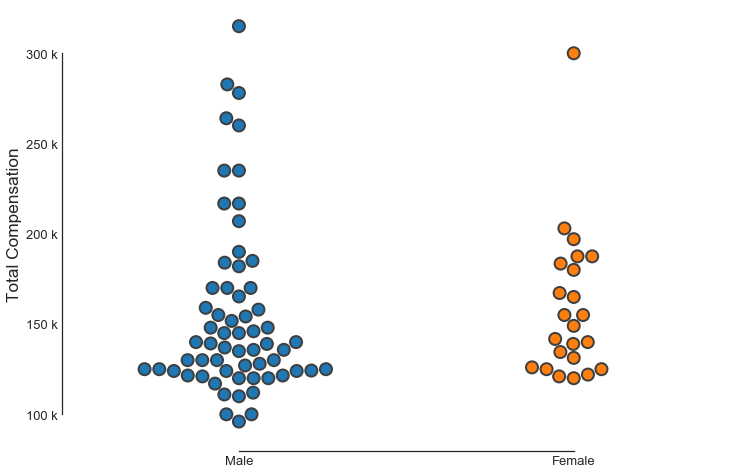

In [17]:
order = df_tmp.groupby(["gender"])["total_recurring_comp"].median().sort_values(ascending=False).index.values
  
fig = make_plot(
    df=df_tmp,
    x="gender",
    y="total_recurring_comp",
    file="data_science_total_comp_gender",
    y_label="Total Compensation",
    order=["Male", "Female"],
)

# Salary by gender and location

In [18]:
df_tmp = df[df["coarse_region"].isin(["California", "Northeast"])]

In [19]:
frame = df_tmp[["gender", "total_recurring_comp", "coarse_region"]]\
.groupby(["gender", "coarse_region"])\
.agg({"total_recurring_comp": ["count", "median"]})

print(tabulate.tabulate(frame, tablefmt="pipe", headers="keys"))

|                          |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:-------------------------|------------------------------------:|-------------------------------------:|
| ('Female', 'California') |                                   8 |                               167500 |
| ('Female', 'Northeast')  |                                  12 |                               145375 |
| ('Male', 'California')   |                                  24 |                               162100 |
| ('Male', 'Northeast')    |                                  28 |                               135700 |


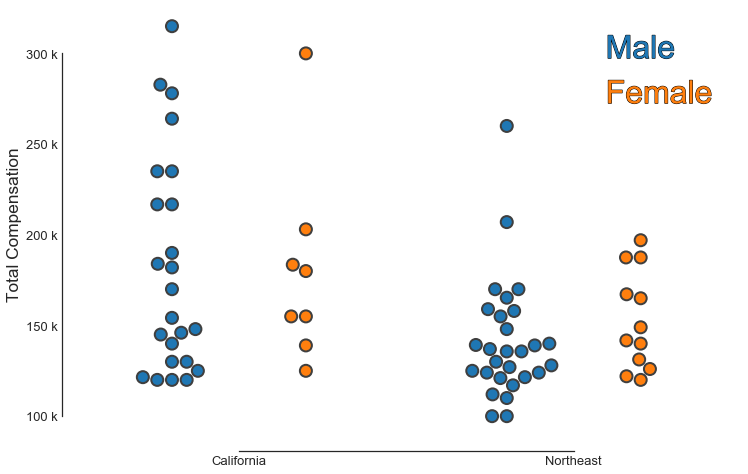

In [20]:
order = df_tmp.groupby(["coarse_region"])["total_recurring_comp"].median().sort_values(ascending=False).index.values
  
fig = make_plot(
    df=df_tmp,
    x="coarse_region",
    y="total_recurring_comp",
    hue="gender",
    file="data_science_total_comp_gender_and_location",
    y_label="Total Compensation",
    order=order,
    legend=True,
)

# Salary by gender and Age

In [21]:
df["age_cat"] = pd.cut(df["age"], [0, 30, 35, 100])
df_tmp = df[df["coarse_region"].isin(["California", "Northeast"])]

In [22]:
frame = df_tmp[["gender", "total_recurring_comp", "age_cat"]]\
.groupby(["gender", "age_cat"])\
.agg({"total_recurring_comp": ["count", "median"]})

print(tabulate.tabulate(frame, tablefmt="pipe", headers="keys"))

|                                               |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:----------------------------------------------|------------------------------------:|-------------------------------------:|
| ('Female', Interval(0, 30, closed='right'))   |                                   5 |                               155000 |
| ('Female', Interval(30, 35, closed='right'))  |                                   8 |                               163750 |
| ('Female', Interval(35, 100, closed='right')) |                                   5 |                               180000 |
| ('Male', Interval(0, 30, closed='right'))     |                                  18 |                               139625 |
| ('Male', Interval(30, 35, closed='right'))    |                                  21 |                               148000 |
| ('Male', Interval(35, 100, closed='right'))   |                                   8 |                        

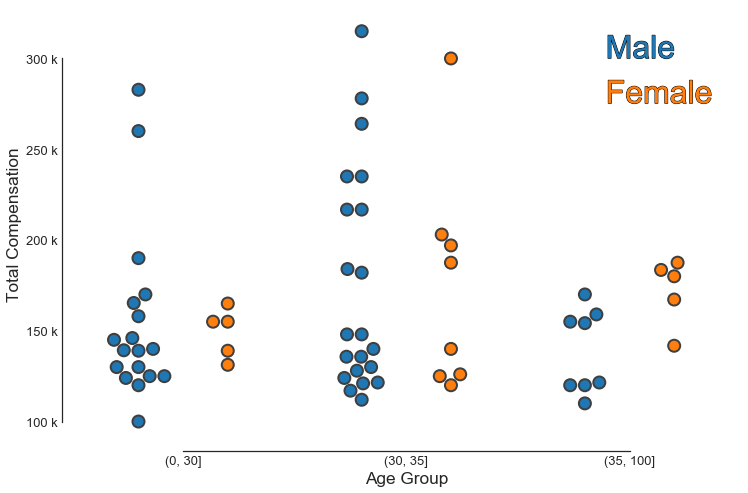

In [23]:
order = df_tmp["age_cat"].unique().sort_values()[0:3]
  
fig = make_plot(
    df=df_tmp,
    x="age_cat",
    y="total_recurring_comp",
    hue="gender",
    file="data_science_total_comp_gender_and_age",
    y_label="Total Compensation",
    x_label="Age Group",
    order=order,
    legend=True,
)